In [2]:
# ==============================
# Energy-Based Learning Schemes
# ==============================

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

class Network:
    def __init__(self, name, external_world, hyper, 
                 neg_phase, pos_phase,
                 activation=torch.sigmoid, energy_fn=None, relax_fn=None):
        self.external_world = external_world
        self.hyper = hyper
        sizes = [external_world.x.shape[1]] + hyper["hidden_sizes"] + [hyper.get("output_size", len(torch.unique(external_world.y)))]
        self.biases = [torch.zeros(s) for s in sizes]
        self.weights = [torch.empty((a, b)).uniform_(-np.sqrt(6/(a+b)), np.sqrt(6/(a+b))) for a, b in zip(sizes[:-1], sizes[1:])]
        self.persistent = [torch.zeros(external_world.size_dataset, s) for s in sizes[1:]]
        self.batch_size = hyper["batch_size"]
        self.index = 0
        self.activation = activation
        self.energy_fn = energy_fn
        self.neg_phase = neg_phase
        self.pos_phase = pos_phase
        self.relax_fn = relax_fn
        if("beta" in hyper):
            self.beta = hyper["beta"]

    def update_mini_batch_index(self, i):
        b = self.batch_size
        self.index = i
        self.x = self.external_world.x[i*b:(i+1)*b]
        self.y = self.external_world.y[i*b:(i+1)*b]
        self.y_onehot = F.one_hot(self.y, num_classes=self.weights[-1].shape[1]).float()
        self.layers = [self.x] + [p[i*b:(i+1)*b] for p in self.persistent]

    def normalize(self, x):
        return (x - x.min(0)[0]) / (x.max(0)[0] - x.min(0)[0] + 1e-5) - x.mean(0)

    def energy(self, layers):
        return self.energy_fn(layers, self.weights, self.biases) if self.energy_fn else torch.tensor(0.)

    def cost(self, layers):
        return ((layers[-1] - self.y_onehot) ** 2).sum(1)

    def measure(self):
        E = self.energy(self.layers).mean().item()
        C = self.cost(self.layers).mean().item()
        top_vals, top_idxs = self.layers[-1].topk(2, dim=1)
        err = (~((top_idxs[:,0] == self.y) & (top_vals[:,0] - top_vals[:,1] > 1e-3))).float().mean().item()
        return E, C, err

    def forward(self, batch, iters):
        self.x, self.y = batch
        self.y_onehot = F.one_hot(self.y, num_classes=self.weights[-1].shape[1]).float()
        self.layers = [self.x] + [p[:self.x.size(0)] for p in self.persistent]
        self.neg_phase(self, iters)
        return self.measure()

    def backward(self, output, iters=10, clamped=[-1]):
        layers = self.layers.copy(); layers[-1] = output
        layers = self.relax_fn(self, layers, iters, clamped) if self.relax_fn else layers
        s, e = self.index * self.batch_size, (self.index + 1) * self.batch_size
        for i, l in enumerate(layers[1:]):
            self.persistent[i][s:e] = l.detach()
        self.layers = [self.x] + [p[s:e] for p in self.persistent]
        return layers[0]

    def train(self, plot=False):
        hist = {"Energy": [], "Cost": [], "Error": []}
        EPOCHS = self.hyper["n_epochs"]
        ALPHAS = self.hyper["alphas"]
        for epoch in range(EPOCHS):
            for i in range(self.external_world.size_dataset // self.batch_size):
                self.update_mini_batch_index(i)
                self.neg_phase(self, self.hyper["n_it_neg"])
                self.pos_phase(self, self.hyper["n_it_pos"], *ALPHAS)
            E, C, err = self.measure()
            hist["Energy"].append(E)
            hist["Cost"].append(C)
            hist["Error"].append(err * 100)
            # print(f"Epoch {epoch+1}/{EPOCHS} | E={E:.2f} C={C:.5f} Error={err*100:.2f}%")
            if plot and epoch in [0, EPOCHS-1]:
                self.plot_weights_verbose(epoch)
        if plot:
            fig, axes = plt.subplots(1, 3, figsize=(18, 4))
            for ax, (k, c) in zip(axes, [("Energy", "blue"), ("Cost", "orange"), ("Error", "red")]):
                ax.plot(hist[k], label=k, color=c)
                ax.set_title(f"{k} over Epochs")
            plt.tight_layout(); plt.show()
        return np.mean(hist["Error"][-4:])
    

    def plot_weights_verbose(self, epoch=None, sample_idx=0):
        import matplotlib.pyplot as plt
        import networkx as nx

        G = nx.DiGraph()
        labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(self.hyper["hidden_sizes"]))] + ['Output']
        sizes = [self.weights[0].shape[0]] + [w.shape[1] for w in self.weights]

        # Collect activations and biases
        if hasattr(self, 'layers'):
            activations = [layer[sample_idx].detach().cpu().numpy() for layer in self.layers]
        else:
            activations = [np.zeros(s) for s in sizes]
        biases = [b.detach().cpu().numpy() for b in self.biases]

        # Add nodes
        for layer_idx, size in enumerate(sizes):
            for node_idx in range(size):
                label = f"{labels[layer_idx]} {node_idx}\nact={activations[layer_idx][node_idx]:.2f}\nbias={biases[layer_idx][node_idx]:.2f}"
                G.add_node((layer_idx, node_idx), label=label, layer=layer_idx, act=activations[layer_idx][node_idx])

        # Add edges with weight
        edge_labels = {}
        edge_weights = []
        for layer_idx, W in enumerate(self.weights):
            for i in range(W.shape[0]):
                for j in range(W.shape[1]):
                    weight = W[i, j].item()
                    u = (layer_idx, i)
                    v = (layer_idx + 1, j)
                    G.add_edge(u, v, weight=weight)
                    edge_labels[(u, v)] = f"{weight:.2f}"
                    edge_weights.append(weight)

        # Normalize edge weights for coloring
        edge_weights = np.array(edge_weights)
        norm = plt.Normalize(vmin=-np.abs(edge_weights).max(), vmax=np.abs(edge_weights).max())
        cmap = plt.cm.RdBu

        # Layout and drawing
        pos = nx.multipartite_layout(G, subset_key='layer')
        fig, ax = plt.subplots(figsize=(10, 5))

        # Draw edges
        nx.draw_networkx_edges(
            G, pos, ax=ax,
            edge_color=edge_weights,
            edge_cmap=cmap,
            edge_vmin=norm.vmin,
            edge_vmax=norm.vmax,
            width=2.0,
            connectionstyle='arc3,rad=0.15',
            arrowsize=12
        )

        # Draw nodes with activation as color
        node_colors = [G.nodes[n]['act'] for n in G.nodes]
        nodes = nx.draw_networkx_nodes(G, pos, ax=ax, node_size=1000, node_color=node_colors, cmap=plt.cm.viridis)

        # Draw labels on nodes
        node_labels = {n: G.nodes[n]['label'] for n in G.nodes}
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=7)

        # Draw edge labels (weights)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

        # Colorbar for edges
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array(edge_weights)
        fig.colorbar(sm, ax=ax, label="Weight")

        title = f"Network Visualization (Epoch {epoch}" if epoch is not None else "Network Visualization"
        title += f", Sample {sample_idx})"
        ax.set_title(title)
        ax.axis('off')
        plt.tight_layout()
        plt.show()




# ---------- Activation / Normalization ----------
def normalize(x):
    return (x - x.min(0)[0]) / (x.max(0)[0] - x.min(0)[0] + 1e-5) - x.mean(0)

# ---------- Relaxation Dynamics (for CHL/EP/PC) ----------
def relax(network, layers, iters, reverse=False, clamped=None):
    for _ in range(iters):
        new = [layers[-1]] if reverse else [layers[0]]
        rng = range(len(layers)-2, 0, -1) if reverse else range(1, len(layers)-1)
        for k in rng:
            a = network.layers[k-1] if reverse else new[-1]
            b = new[-1] if reverse else layers[k+1]
            w1, w2 = network.weights[k - 1], network.weights[k]
            try:
                h = network.activation(a @ w1 + b @ w2.T + network.biases[k])
            except RuntimeError as e:
                if 'mat1 and mat2 shapes cannot be multiplied' in str(e):
                    raise RuntimeError(f"Shape mismatch at layer {k}: a={a.shape}, w1={w1.shape}, b={b.shape}, w2.T={w2.T.shape}") from e
                else:
                    raise
            new.append(normalize(h))
        new.append(network.layers[0] if reverse else network.y_onehot)
        layers = list(reversed(new)) if reverse else [network.x] + new[1:]
    return layers

# ---------- CHL ----------
def chl_neg(network, steps):
    layers = [x.clone() for x in network.layers]
    for _ in range(steps):
        new = [layers[0]]
        for k in range(1, len(layers) - 1):
            h = network.activation(
                new[-1] @ network.weights[k - 1] + 
                layers[k + 1] @ network.weights[k].T + 
                network.biases[k]
            )
            new.append(network.normalize(h))
        out = network.activation(new[-1] @ network.weights[-1] + network.biases[-1])
        new.append(out)
        layers = [layers[0]] + new[1:]
    s, e = network.index * network.batch_size, (network.index + 1) * network.batch_size
    for i, l in enumerate(layers[1:]):
        network.persistent[i][s:e] = l.detach()
    network.layers = [network.x] + [p[s:e] for p in network.persistent]

def chl_pos(network, steps, *alphas):
    clamped = relax(network, network.layers[:-1] + [network.y_onehot], steps, reverse=True)
    for i, delta in enumerate([c - o for c, o in zip(clamped[1:], network.layers[1:])]):
        if i + 1 < len(network.biases):
            network.biases[i + 1] += alphas[i] * delta.mean(0)
        if i < len(network.weights):
            network.weights[i] += alphas[i] * network.layers[i].T @ delta / network.batch_size

# ---------- Equilibrium Propagation (EP) ----------
def ep_neg(network, steps):
    layers = [x.clone() for x in network.layers]
    for _ in range(steps):
        new = [layers[0]]
        for k in range(1, len(layers) - 1):
            h = network.activation(
                new[-1] @ network.weights[k - 1] + 
                layers[k + 1] @ network.weights[k].T + 
                network.biases[k]
            )
            new.append(network.normalize(h))
        out = network.activation(new[-1] @ network.weights[-1] + network.biases[-1])
        out -= network.beta * (out - network.y_onehot)
        new.append(out)
        layers = [layers[0]] + new[1:]
    s, e = network.index * network.batch_size, (network.index + 1) * network.batch_size
    for i, l in enumerate(layers[1:]):
        network.persistent[i][s:e] = l.detach()
    network.layers = [network.x] + [p[s:e] for p in network.persistent]

def ep_pos(network, steps, *alphas):
    clamped = relax(network, network.layers, steps)
    for i, delta in enumerate([c - o for c, o in zip(clamped[1:], network.layers[1:])]):
        if i + 1 < len(network.biases):
            network.biases[i + 1] += alphas[i] * delta.mean(0)
        if i < len(network.weights):
            network.weights[i] += alphas[i] * network.layers[i].T @ delta / network.batch_size

# ---------- First-Step Gradient Approximation ----------
def first_step_pos(network, steps, *alphas):
    layers = [x.clone() for x in network.layers]
    out = layers[-2] @ network.weights[-1] + network.biases[-1]
    nudged = network.activation(out - network.beta * (network.activation(out) - network.y_onehot))
    delta = nudged - network.activation(out)
    for i in range(len(network.weights)):
        if i + 1 < len(network.biases):
            network.biases[i + 1] += alphas[i] * delta.mean(0)
        network.weights[i] += alphas[i] * network.layers[i].T @ delta / network.batch_size

# ---------- PC-Nudge ----------
def pcnudge_neg(network, steps):
    layers = [x.clone() for x in network.layers]
    for _ in range(steps):
        new = [layers[0]]
        for k in range(1, len(layers) - 1):
            pred = network.activation(new[-1] @ network.weights[k - 1] + network.biases[k])
            error = layers[k] - pred
            new.append(network.normalize(pred + error))
        out = network.activation(new[-1] @ network.weights[-1] + network.biases[-1])
        out -= network.beta * (out - network.y_onehot)
        new.append(out)
        layers = [layers[0]] + new[1:]
    s, e = network.index * network.batch_size, (network.index + 1) * network.batch_size
    for i, l in enumerate(layers[1:]):
        network.persistent[i][s:e] = l.detach()
    network.layers = [network.x] + [p[s:e] for p in network.persistent]

def pcnudge_pos(network, steps, *alphas):
    clamped = relax(network, network.layers, steps)
    for i, delta in enumerate([c - o for c, o in zip(clamped[1:], network.layers[1:])]):
        if i + 1 < len(network.biases):
            network.biases[i + 1] += alphas[i] * delta.mean(0)
        if i < len(network.weights):
            network.weights[i] += alphas[i] * network.layers[i].T @ delta / network.batch_size


In [3]:
import numpy as np
import torch

class ExternalWorld:
    def __init__(self, x_values, y_values):
        self.x = torch.tensor(x_values, dtype=torch.float32)
        self.y = torch.tensor(y_values, dtype=torch.int64)
        self.size_dataset = len(self.x)

xor_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
xor_y = np.array([0, 1, 1, 0], dtype=np.int64)
xor_world = ExternalWorld(xor_x, xor_y)


In [5]:
import ipywidgets as widgets
from IPython.display import display

# Sliders for 4 weights and 2 biases
w_sliders = [widgets.FloatSlider(value=0.0, min=-2, max=2, step=0.1, description=f'w{i}') for i in range(4)]
b_sliders = [widgets.FloatSlider(value=1.0, min=-2, max=2, step=0.1, description=f'b{i}') for i in range(2)]


In [6]:
def run_xor_trial(w0, w1, w2, w3, b0, b1, plot=True):
    init = torch.tensor([w0, w1, w2, w3, b0, b1])
    xor_net = Network(
        name="xor_trial",
        external_world=xor_world,
        hyper={
            "hidden_sizes": [2, 1],
            "output_size": 2,
            "batch_size": 4,
            "n_epochs": 20,
            "n_it_neg": 1,
            "n_it_pos": 1,
            "alphas": [0.1, 0.1, 0.01],
            "beta": 0.1,
            "activation": torch.relu
        },
        neg_phase=ep_neg,
        pos_phase=ep_pos,
        relax_fn=relax
    )

    with torch.no_grad():
        xor_net.weights[0][:] = init[0:4].reshape(2, 2)
        xor_net.weights[1][:] = init[4:6].reshape(2, 1)

    error = xor_net.train(plot=plot)
    print("Final XOR Error:", error)
    xor_net.update_mini_batch_index(0)
    print("Output logits:", xor_net.layers[-1].detach().numpy())


In [7]:
ui = widgets.VBox(w_sliders + b_sliders)
out = widgets.interactive_output(run_xor_trial, {
    'w0': w_sliders[0], 'w1': w_sliders[1],
    'w2': w_sliders[2], 'w3': w_sliders[3],
    'b0': b_sliders[0], 'b1': b_sliders[1]
})

display(ui, out)


Output()

100%|██████████| 81/81 [00:02<00:00, 35.17it/s]
/var/folders/q0/hw11rnjs0g1cnny7p5swsnv40000gn/T/ipykernel_98932/572542143.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  coolwarm = plt.cm.get_cmap("coolwarm", 256)


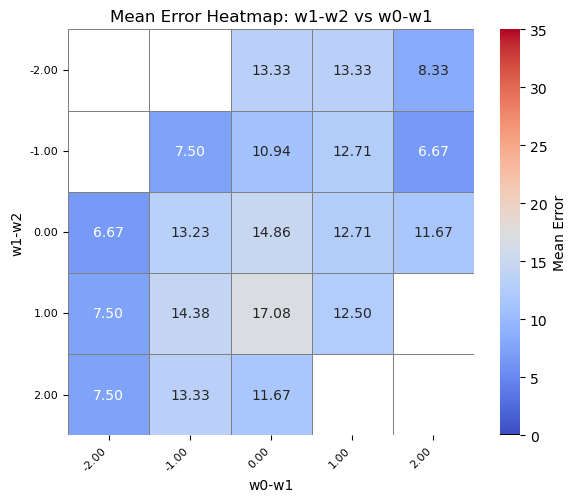

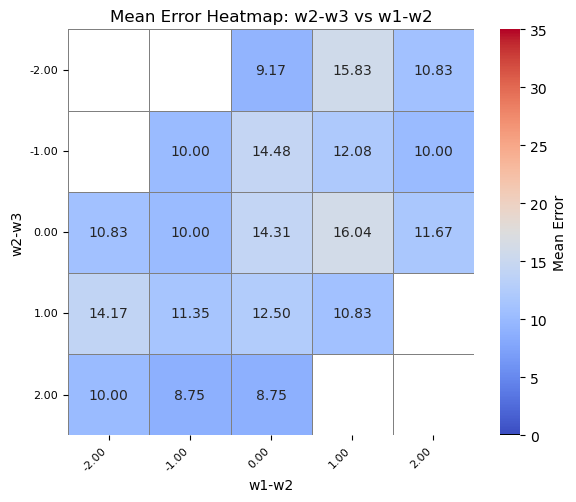

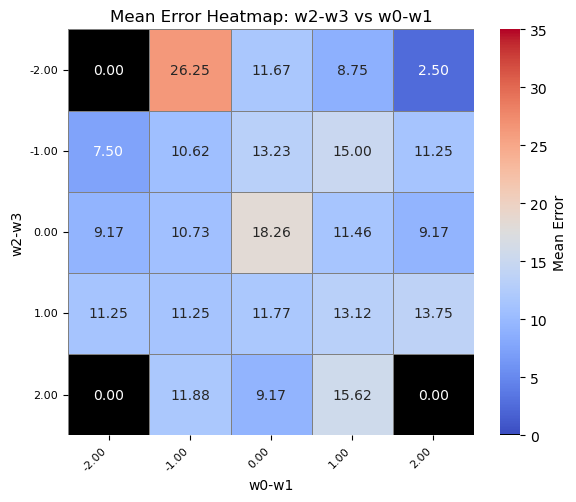

,w0-w1,w1-w2,w2-w3,error,all_errors
17,-1.0,-1.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
20,-2.0,2.0,-2.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22,-2.0,1.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
24,-2.0,0.0,2.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
38,0.0,1.0,-2.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [4]:
import numpy as np
import torch

class ExternalWorld:
    def __init__(self, x_values, y_values):
        self.x = torch.tensor(x_values, dtype=torch.float32)
        self.y = torch.tensor(y_values, dtype=torch.int64)
        self.size_dataset = len(self.x)

xor_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
xor_y = np.array([0, 1, 1, 0], dtype=np.int64)
xor_world = ExternalWorld(xor_x, xor_y)



import torch
import numpy as np
import pandas as pd
from itertools import product
from tqdm import tqdm

# Sweep config
W_RANGE = torch.linspace(-1, 1, 3)  # resolution
N_TRIALS = 10

errors = []
diffs = []
inits = []
all_errors = []

vals = list(product(W_RANGE, repeat=4))

# XOR weight sweep
for w0, w1, w2, w3 in tqdm(vals):
    trial_errors = []
    trial_inits = []

    for _ in range(N_TRIALS):
        init = torch.tensor([w0, w1, w2, w3, 1.0, 1.0])
        trial_inits.append(init)

        xor_net = Network(
            name="xor_trial",
            external_world=xor_world,
            hyper={
                "hidden_sizes": [2, 1],
                "output_size": 2,
                "batch_size": 4,
                "n_epochs": 10,
                "n_it_neg": 1,
                "n_it_pos": 1,
                "alphas": [0.1, 0.1, 0.01],
                "beta": 0.1,
                "activation": torch.relu
            },
            neg_phase=ep_neg,
            pos_phase=ep_pos,
            relax_fn=relax
        )

        with torch.no_grad():
            xor_net.weights[0][:] = init[0:4].reshape(2, 2)
            xor_net.weights[1][:] = init[4:6].reshape(2, 1)

        error = xor_net.train(plot=False)
        trial_errors.append(error)

    avg_error = np.mean(trial_errors)
    all_errors.append(trial_errors)
    diffs.append([
        round((w0 - w1).item(), 4),
        round((w1 - w2).item(), 4),
        round((w2 - w3).item(), 4),
    ])
    errors.append(avg_error)

# Create DataFrame with aggregated errors
df = pd.DataFrame(diffs, columns=["w0-w1", "w1-w2", "w2-w3"])
df["error"] = errors
df["all_errors"] = all_errors

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# === Colormap Setup ===
vmin = 0.0
vmax = max(df["error"])
coolwarm = plt.cm.get_cmap("coolwarm", 256)
colors = [(0, 0, 0)] + [coolwarm(i) for i in range(1, 256)]
custom_cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# === Heatmap Plotter ===
def plot_error_heatmap(xcol, ycol, zcol="error"):
    df_ = df[[xcol, ycol, zcol]].copy()
    pivot = df_.pivot_table(index=ycol, columns=xcol, values=zcol, aggfunc="mean")
    pivot.index = pivot.index.astype(float).round(2)
    pivot.columns = pivot.columns.astype(float).round(2)
    pivot = pivot.sort_index().sort_index(axis=1)

    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(
        pivot,
        cmap=custom_cmap,
        norm=norm,
        annot=True,
        fmt=".2f",
        cbar_kws={'label': 'Mean Error'},
        square=True,
        linewidths=0.5,
        linecolor='gray'
    )
    ax.set_title(f"Mean Error Heatmap: {ycol} vs {xcol}")
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)

    ax.set_xticklabels([f"{float(label.get_text()):.2f}" for label in ax.get_xticklabels()],
                       rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels([f"{float(label.get_text()):.2f}" for label in ax.get_yticklabels()],
                       rotation=0, fontsize=8)

    plt.tight_layout()
    plt.show()

plot_error_heatmap("w0-w1", "w1-w2")
plot_error_heatmap("w1-w2", "w2-w3")
plot_error_heatmap("w0-w1", "w2-w3")

# List and return configs where all trials resulted in zero error
zero_error_configs = df[df["all_errors"].apply(lambda errs: all(e < 1e-4 for e in errs))]
zero_error_configs.head()
